In [2]:
%matplotlib inline
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
from pprint import pprint
import copy

from omnigloter import analyse_network as analysis


In [3]:
def target_frequency_error(target, spikes, power=1):
    err = []
    if power == 1:
        err[:] = [np.abs(len(times) - target) for times in spikes]
    else:
        err[:] = [np.abs(len(times) - target)**power for times in spikes]

    return np.sum(err)

def mean_target_frequency_error(target, spikes, power=1):
    return target_frequency_error(target, spikes, power) / float(len(spikes))

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def to_dict(npz):
    d = {}
    for k in npz:
        try:
            d[k] = npz[k].item()
        except:
            d[k] = npz[k]
    return d

def get_test_label_idx(data):
    n_class = data['params']['sim']['num_classes']
    n_train_per_class = data['params']['sim']['samples_per_class']
    n_epochs = data['params']['sim']['num_epochs']
    return n_class * n_train_per_class * n_epochs

def get_test_start_t(data):
    dt = data['params']['sim']['sample_dt']
    n_train = get_test_label_idx(data)
    return n_train * dt

def get_test_spikes_and_labels(data):
    spk = data['recs']['output'][0]['spikes']
    lbl = data['input']['labels']
    dt = data['params']['sim']['sample_dt']
    start_t = get_test_start_t(data)
    start_idx = get_test_label_idx(data)
    out_spk = []
    out_ids = lbl[start_idx:]
    for times in spk:
        ts = np.asarray(times)
        whr = np.where(ts >= start_t)
        out_spk.append(ts[whr])
    return out_spk, out_ids
        
DEF_MARKERS = ['v', '<', 'o', 's', 'P', '*', 'X', 'd', 'p'] * 2
cmap = matplotlib.cm.get_cmap('gist_rainbow')
DEF_COLORS = [cmap(v) for v in np.arange(0., 1., 1./20.)]
# ACTIVITY_THRESHOLD = 0.2 * NUM_OUTPUT
# ABOVE_THRESH_W = 0.5 / NUM_CLASSES
# MAX_VECTOR_DIST = 200.0

def vectors_above_threshold(vectors, threshold):
    vs = [np.sum(v) for v in vectors]
#     print(vs, threshold)
    return [i for i, s in enumerate(vs) if s >= threshold]

def plot_test_map(labels, spikes, start_t, dt, ms=1, markers=DEF_MARKERS, 
                  colors=DEF_COLORS, edgewidth=1):
    unique = np.unique(labels)
    counts = {k: 0 for k in unique}
    
    n_lbl = unique.size
    lw = np.ceil(np.sqrt(n_lbl))
    dlw = 0.8/lw
    n_out = len(spikes)
    w = np.ceil(np.sqrt(n_out))
    
    for x in np.arange(w+1):
        plt.axvline(x, linewidth=1, color='gray')
        plt.axhline(x, linewidth=1, color='gray')

    for nid, times in enumerate(spikes): 
        y = nid // w
        x = nid % w
        for t in times:
            lbl_idx = int((t - start_t) // dt)
            if lbl_idx >= len(labels):
                continue
            lbl = labels[lbl_idx]
            mrk = markers[lbl]
            ly = 0.1 + (lbl // lw) * dlw
            lx = 0.1 + (lbl % lw) * dlw
            lgd = "{:02d}".format(lbl) if counts[lbl] == 0 else None 
            clr = colors[lbl]
            counts[lbl] += 1
            plt.plot(x + lx, y + ly, linestyle='none', color=clr, marker=mrk, 
                     markersize=ms, label=lgd, markeredgewidth=edgewidth, 
                     markeredgecolor='black')
            
    handles, labels = plt.gca().get_legend_handles_labels()
    slbls, shdls = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    plt.legend(shdls, slbls, bbox_to_anchor=(1.01, 1.01))

def plot_test_map_single(labels, spikes, start_t, dt, ms=1, 
                         markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1):
    unique = np.unique(labels)
    counts = {k: 0 for k in unique}
    
    n_lbl = unique.size
    lw = np.ceil(np.sqrt(n_lbl))
    dlw = 0.8/lw
    n_out = len(spikes)
    w = np.ceil(np.sqrt(n_out))

    lbls_per_nrn = get_labels_per_neuron(labels, spikes, start_t, dt)
    ax = plt.gca()
    ax.set_title('Categories (symbol/color) per neuron (squares)')
    for x in np.arange(w+1):
        plt.plot([x, x], [0, w], '-', linewidth=1, color='gray')
        plt.plot([0, w], [x, x], '-', linewidth=1, color='gray')
#         plt.axvline(x, linewidth=1, color='gray')
#         plt.axhline(x, linewidth=1, color='gray')
        
    for nid, times in enumerate(spikes): 
        y = nid // w
        x = nid % w
        many = False
        unique_lbl_p_nrn = np.unique(lbls_per_nrn[nid])
        if len(unique_lbl_p_nrn) > 1:
            many = True
            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), 1, 1, linewidth=1,
                    edgecolor='black', facecolor='red', alpha=0.3,
                    fill=True, hatch='x')

            # Add the patch to the Axes
            ax.add_patch(rect)
#             continue
        elif len(unique_lbl_p_nrn) == 1:
            many = False
            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), 1, 1, linewidth=0,
                    edgecolor='none', facecolor='green', alpha=0.3)

            # Add the patch to the Axes
            ax.add_patch(rect)
#             continue

        for t in times:
            lbl_idx = int((t - start_t) // dt)
            if lbl_idx >= len(labels):
                continue
                
            lbl = labels[lbl_idx]
            mrk = markers[lbl]
            ly = 0.1 + (lbl // lw) * dlw
            lx = 0.1 + (lbl % lw) * dlw
            lgd = "{:02d}".format(lbl) if counts[lbl] == 0 and not many else None 
            clr = colors[lbl]
            if not many:
                counts[lbl] += 1
            plt.plot(x + lx, y + ly, linestyle='none', color=clr, marker=mrk, 
                     markersize=ms, label=lgd, markeredgewidth=edgewidth, 
                     markeredgecolor='black')
    
    try:
        handles, labels = plt.gca().get_legend_handles_labels()
        slbls, shdls = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.legend(shdls, slbls, bbox_to_anchor=(1.01, 1.01))
    except:
        print("all neurons where activated by many classes")

    ax.set_xlim(0, w)
    ax.set_ylim(0, w)
    
    _ticks = 0.5 + np.arange(w)
    ax.set_yticks(_ticks)
    ax.set_yticklabels([f"{i: 2d}" for i in np.arange(w, dtype='int')])
    ax.set_xticks(_ticks)
    ax.set_xticklabels([f"{i: 2d}" for i in np.arange(w, dtype='int')])
    
    ax.set_xlabel(r'Neuron "$x \;coordinate$"')
    ax.set_ylabel(r'Neuron "$y \;coordinate$"')
    
def get_labels_per_neuron(labels, spikes, start_t, dt):
    lbls_per_nrn = {k: [] for k in range(len(spikes))}

    for nid, times in enumerate(spikes):
        ts = np.asarray(times).astype('int')
        ts -= int(start_t)
        ts //= int(dt)
        ids = ts[np.where(ts < len(labels))]
        for lbl in [labels[i] for i in ids]:
            lbls_per_nrn[nid].append(lbl)
    return lbls_per_nrn

def get_neurons_per_label(labels, spikes, start_t, dt):
    unique = np.unique(labels)
    nrns_per_lbl = {k: [] for k in unique}
    for nid, times in enumerate(spikes):
        ts = np.asarray(times).astype('int')
        ts -= int(start_t)
        ts //= int(dt)
        ids = ts[np.where(ts < len(labels))]
        for lbl in [labels[i] for i in ids]:
            nrns_per_lbl[lbl].append(nid)

    return nrns_per_lbl

def mean_per_sample_class_distance(_activity_per_sample, labels, n_out):
    return np.mean(
        per_sample_class_distance(_activity_per_sample, labels, n_out))

def per_sample_class_distance(_activity_per_sample, labels, n_out):
    class_samples = {}
    max_active = 0
    for idx, lbl in enumerate(labels):
        lbl_list = class_samples.get(lbl, [])
        lbl_list.append( _activity_per_sample[idx])
        class_samples[lbl] = lbl_list
        
        if len(_activity_per_sample[idx]) > max_active:
            max_active = len(_activity_per_sample[idx])

    if max_active == 0:
        return 0
    
    v0 = np.zeros(n_out)
    v1 = np.zeros(n_out)
    dists = []
    classes = sorted(class_samples.keys())
    for idx0, cls0 in enumerate(classes[:-1]):
        for cls1 in classes[idx0+1:]:
            for samp0 in class_samples[cls0]:
                v0[:] = 0
                if len(samp0):
                    v0[samp0] = 1
                for samp1 in class_samples[cls1]:
                    v1[:] = 0
                    if len(samp1):
                        v1[samp1] = 1
                    
                    dists.append( np.sum(np.abs(v0 - v1)) )

    return dists

def error_sample_target_activity(target, activity_per_sample):
    act = np.asarray([len(ids) for ids in activity_per_sample])
    return np.sum(np.abs(act - target))


def activity_per_sample(labels, spikes, start_t, dt):
    end_t = start_t + len(labels) * dt
    aps = [[] for _ in labels]
    for st in np.arange(start_t, end_t, dt):
        et = st + dt
        idx = int((st - start_t) // dt)
        for nid, times in enumerate(spikes):
            ts = np.asarray(times)
            whr = np.where(np.logical_and(st <= ts, ts < et))[0]
            if len(whr):
                aps[idx].append(nid)
    return aps


def get_max_t(spikes):
    max_t = -1
    max_id = -1
    for nid, times in enumerate(spikes):
        if len(times):
            local_max_t = np.max(times)
            if local_max_t > max_t:
                max_t = local_max_t
                max_id = nid
    return max_t, max_id


def get_vectors(neurons_per_label):
    vectors = {}
    for k in neurons_per_label:
        v = np.zeros(len(out_spikes))
        v[neurons_per_label[k]] = 1.
        vectors[k] = v
    return vectors

def mdist(v0, v1, normalize=True):
    s = 0.
    if np.sum(v0) >= 1 and np.sum(v1) >= 1:
        s = np.sum(np.abs(v0 - v1))
        if normalize:
            s *= 1./(np.sum(v0) + np.sum(v1))
    return s

def get_distances(neurons_per_label):
    n_labels = len(neurons_per_label)
    vectors = get_vectors(neurons_per_label)
    dists = np.zeros((n_labels, n_labels))
    labels = sorted(neurons_per_label.keys())
    for k0 in labels[:-1]:
        for k1 in labels[k0+1:]:
            s = mdist(vectors[k0], vectors[k1])
                
            dists[k0, k1] = s
            dists[k1, k0] = dists[k0, k1]

    return dists


def mht(a, b):
    return np.sum(np.abs(a - b))


def max_dist(vecs):
    max_d = -1
    for i, v0 in enumerate(vecs[:-1]):
        for v1 in vecs[i+1:]:
            d = mht(v0, v1)
            if d > max_d:
                max_d = d
    return max_d

def empty(st, dt, spikes):
    for ts in spikes:
        ts = np.asarray(ts)
        whr = np.where(np.logical_and(st <= ts, ts < st + dt))[0]
        if len(whr):
            return False
    return True

def high_rate(start_t, spikes, rate_threshold):
    ids = []
    rates = []
    for nid, ts in enumerate(spikes):
        ts = np.asarray(ts)
        whr = np.where(start_t <= ts)[0]
        if len(whr) >= rate_threshold:
            ids.append(nid)
            rates.append(len(whr))

    return ids, rates

def average_rate(start_t, spikes):
    rates = []
    for nid, ts in enumerate(spikes):
        ts = np.asarray(ts)
        ts = ts[np.where(start_t <= ts)]
        rates.append(len(ts))
    return np.mean(rates)


def sort_activity_per_sample(labels, act_per_sample):
    classes = sorted(np.unique(labels))
    d = {k: [] for k in classes}
    for i, l in enumerate(labels):
        d[l].append(act_per_sample[i])
    
    saps = []
    for c in classes:
        saps += d[c]
    return saps
    

../titan/data_gen0000000023_ind0000000029.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.01,
 'A_plus': 0.07137997850969464,
 'conn_dist': 12.0,
 'exp_prob': 0.1,
 'expand': 11.43519435239359,
 'mushroom_weight': 1.3966251330017976,
 'out_prob': 0.09179134113529569,
 'out_weight': 1.3972118145418022,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


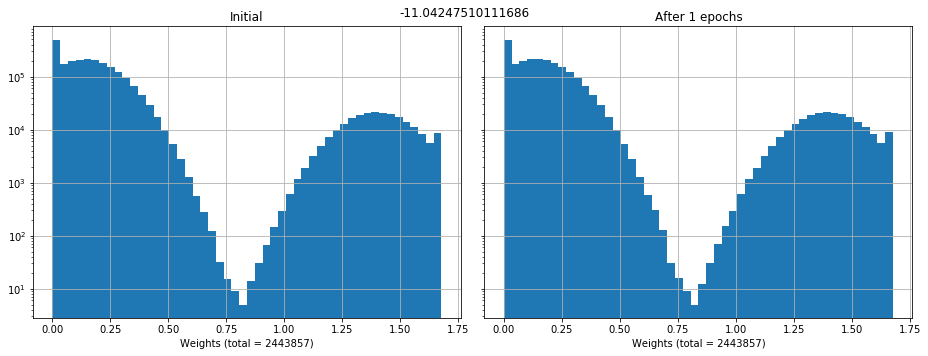

../titan/data_gen0000000023_ind0000000028.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 5.4938004475125215,
 'A_plus': 2.262477961661932,
 'conn_dist': 22.0,
 'exp_prob': 0.045143010371840576,
 'expand': 5.631463488376266,
 'mushroom_weight': 1.114400638934627,
 'out_prob': 0.07687453412199254,
 'out_weight': 1.8225319477084239,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


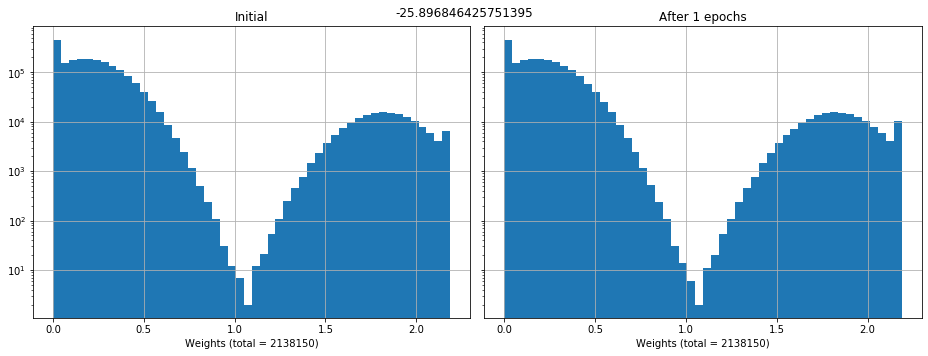

../titan/data_gen0000000023_ind0000000027.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.9604953618153141,
 'A_plus': 4.212442618403642,
 'conn_dist': 21.0,
 'exp_prob': 0.06100090389840249,
 'expand': 12.287900232923242,
 'mushroom_weight': 0.9630138878579223,
 'out_prob': 0.029561637243109416,
 'out_weight': 1.7341299005757569,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


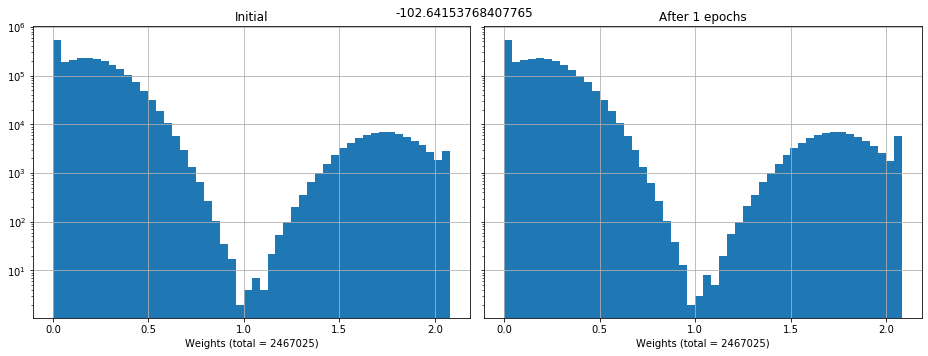

../titan/data_gen0000000023_ind0000000026.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 7.760896318034693,
 'A_plus': 5.308373975869612,
 'conn_dist': 15.0,
 'exp_prob': 0.09545565938917963,
 'expand': 10.02975140988714,
 'mushroom_weight': 1.746718909155592,
 'out_prob': 0.022699256017060264,
 'out_weight': 1.1186261914844748,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}
../titan/data_gen0000000023_ind0000000025.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.01,
 'A_plus': 0.07137997850969464,
 'conn_dist': 12.0,
 'exp_prob': 0.1,
 'expand': 11.43519435239359,
 'mushroom_weight': 1.3966251330017976,
 'out_prob': 0.1,
 'out_weight': 2.0,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


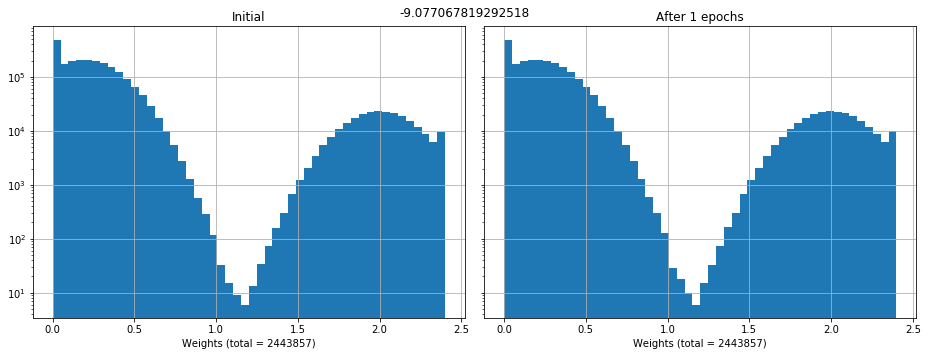

../titan/data_gen0000000023_ind0000000024.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.01,
 'A_plus': 0.07137997850969464,
 'conn_dist': 12.0,
 'exp_prob': 0.1,
 'expand': 11.43519435239359,
 'mushroom_weight': 1.1201174416258106,
 'out_prob': 0.09179134113529569,
 'out_weight': 2.0,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


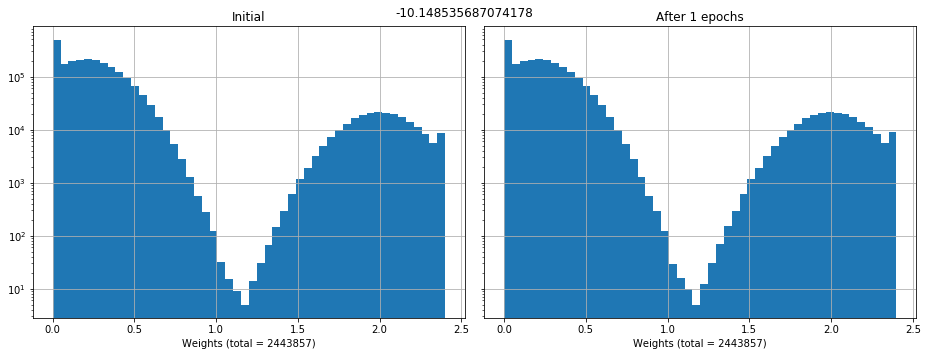

../titan/data_gen0000000023_ind0000000023.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 4.1915307829763995,
 'A_plus': 0.7267242242312889,
 'conn_dist': 18.0,
 'exp_prob': 0.05614590431120253,
 'expand': 10.43714086379627,
 'mushroom_weight': 0.5620071499570644,
 'out_prob': 0.053839062402759055,
 'out_weight': 0.9591803214113186,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


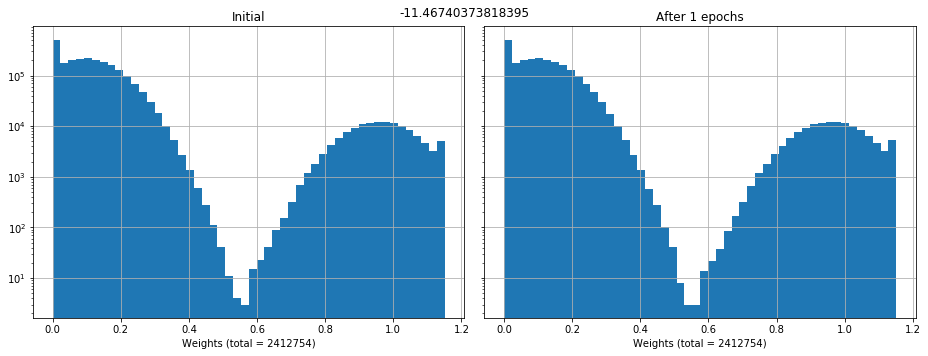

../titan/data_gen0000000023_ind0000000022.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 9.526838488822616,
 'A_plus': 4.282121081589212,
 'conn_dist': 10.0,
 'exp_prob': 0.05833431654306742,
 'expand': 19.23322557021433,
 'mushroom_weight': 0.13673319745883966,
 'out_prob': 0.06285431528996997,
 'out_weight': 0.8696696101140273,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


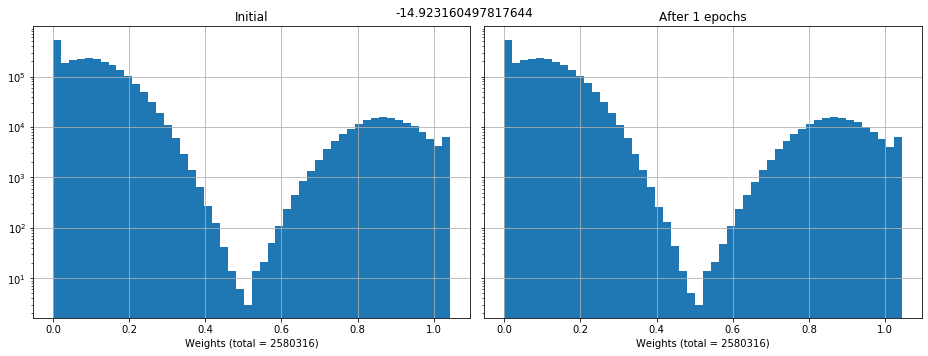

../titan/data_gen0000000023_ind0000000021.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.01,
 'A_plus': 0.01,
 'conn_dist': 12.0,
 'exp_prob': 0.1,
 'expand': 11.43519435239359,
 'mushroom_weight': 1.3966251330017976,
 'out_prob': 0.1,
 'out_weight': 2.0,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


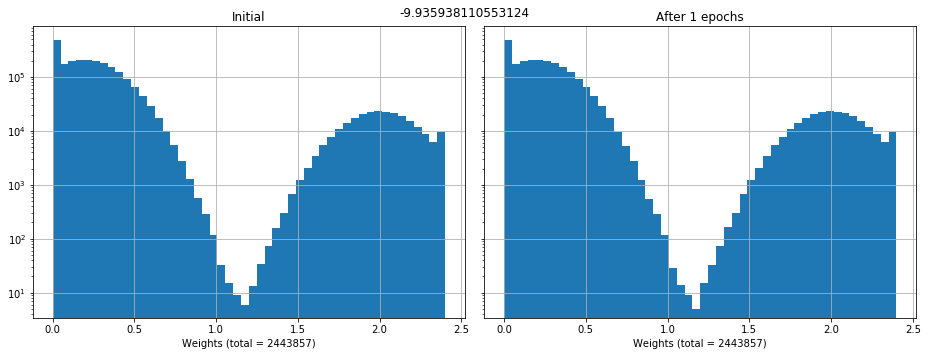

../titan/data_gen0000000023_ind0000000020.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 1.048081880390247,
 'A_plus': 1.2943834386990138,
 'conn_dist': 17.0,
 'exp_prob': 0.05174290253563245,
 'expand': 12.533617334873934,
 'mushroom_weight': 1.3758080897683305,
 'out_prob': 0.08661390544053077,
 'out_weight': 0.9846439903079232,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


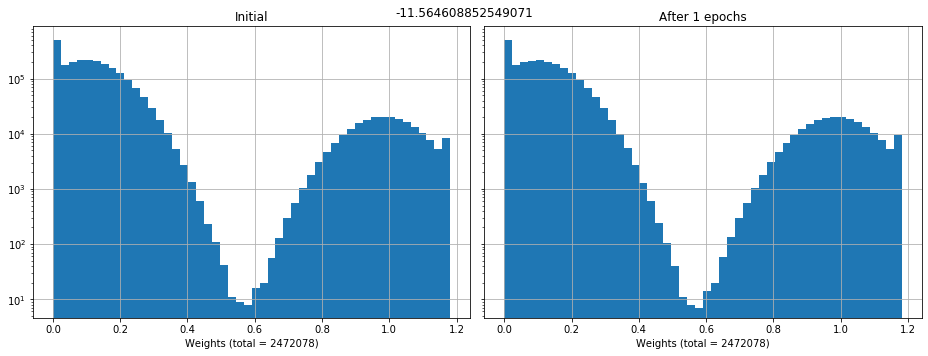

../titan/data_gen0000000023_ind0000000019.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 1.3983387252767439,
 'A_plus': 6.108761412650644,
 'conn_dist': 11.0,
 'exp_prob': 0.0717066811777643,
 'expand': 19.230651564197522,
 'mushroom_weight': 0.3827605805322736,
 'out_prob': 0.01757170661685257,
 'out_weight': 0.20004663863645664,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}
../titan/data_gen0000000023_ind0000000018.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.01,
 'A_plus': 0.07137997850969464,
 'conn_dist': 12.0,
 'exp_prob': 0.1,
 'expand': 13.091076117050758,
 'mushroom_weight': 1.3966251330017976,
 'out_prob': 0.1,
 'out_weight': 2.0,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


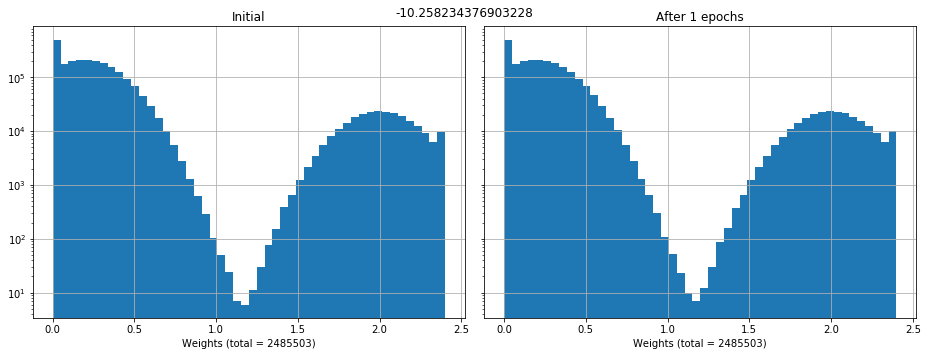

../titan/data_gen0000000023_ind0000000017.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 2.972699711724979,
 'A_plus': 5.7988106160682,
 'conn_dist': 22.0,
 'exp_prob': 0.010369915535088592,
 'expand': 8.530739475816208,
 'mushroom_weight': 0.39741131679457287,
 'out_prob': 0.07077646717240534,
 'out_weight': 0.866477460809044,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


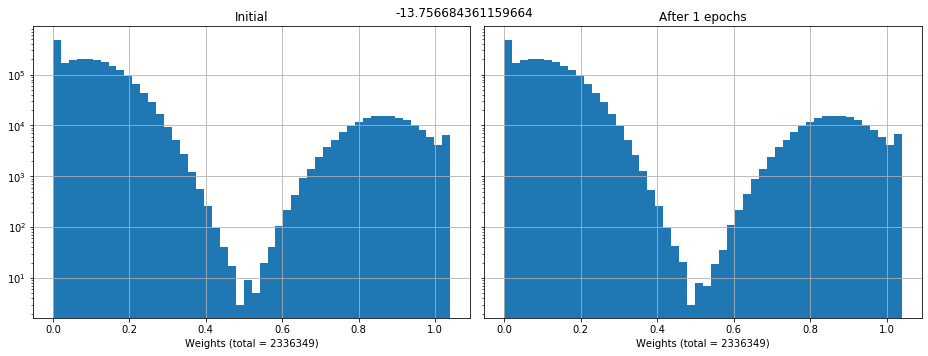

../titan/data_gen0000000023_ind0000000016.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 1.437848838137966,
 'A_plus': 9.531271748126267,
 'conn_dist': 15.0,
 'exp_prob': 0.06458282916294407,
 'expand': 19.67867947301749,
 'mushroom_weight': 0.8792050797539255,
 'out_prob': 0.06301518320107395,
 'out_weight': 2.0,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


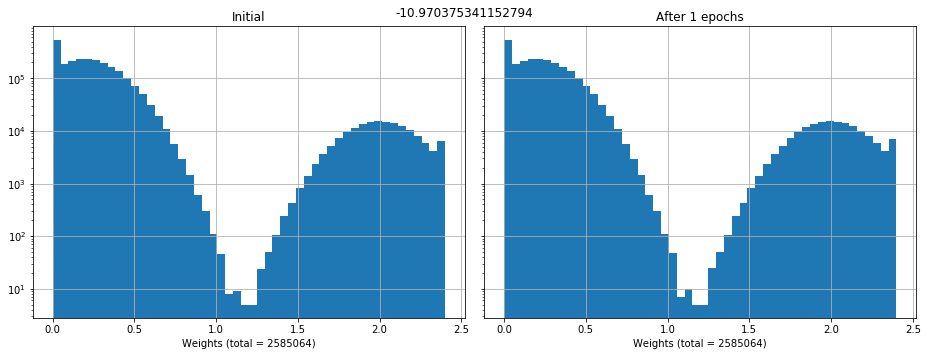

../titan/data_gen0000000023_ind0000000015.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 1.8897040395437557,
 'A_plus': 6.4383119544397305,
 'conn_dist': 6.0,
 'exp_prob': 0.08033413233006502,
 'expand': 19.30540098521618,
 'mushroom_weight': 0.9823932420075888,
 'out_prob': 0.0844359287640394,
 'out_weight': 1.5426343159303413,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


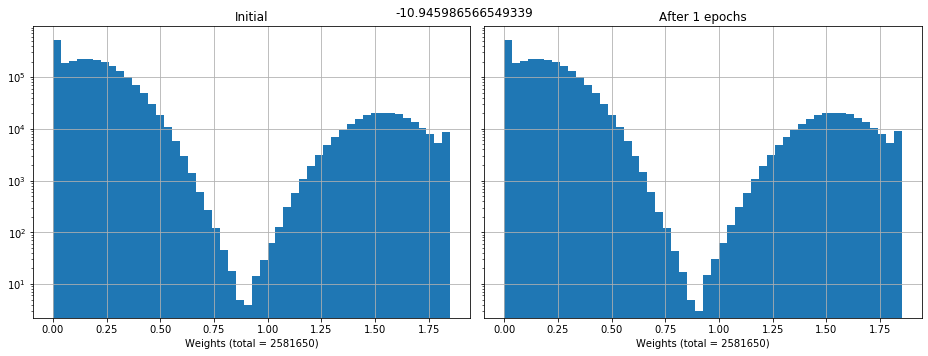

../titan/data_gen0000000023_ind0000000014.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.01,
 'A_plus': 2.2335462337685215,
 'conn_dist': 12.0,
 'exp_prob': 0.1,
 'expand': 11.43519435239359,
 'mushroom_weight': 1.3966251330017976,
 'out_prob': 0.09179134113529569,
 'out_weight': 2.0,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}
../titan/data_gen0000000023_ind0000000013.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 7.961088720828417,
 'A_plus': 6.857226363721414,
 'conn_dist': 23.0,
 'exp_prob': 0.03221310347834891,
 'expand': 17.256517490139018,
 'mushroom_weight': 1.7314875044649813,
 'out_prob': 0.09846225819780823,
 'out_weight': 0.9920524040125251,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


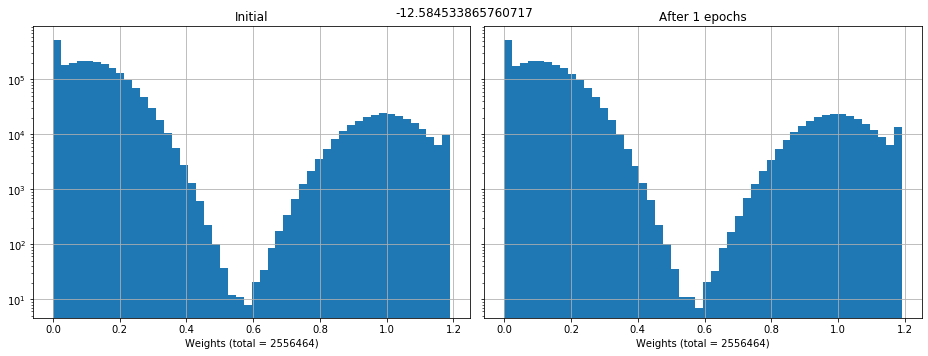

../titan/data_gen0000000023_ind0000000012.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 7.704561289117131,
 'A_plus': 2.7972157105088895,
 'conn_dist': 7.0,
 'exp_prob': 0.01229516192380599,
 'expand': 16.173193102708705,
 'mushroom_weight': 1.8203877431829656,
 'out_prob': 0.010330100259456151,
 'out_weight': 0.7921018012387884,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


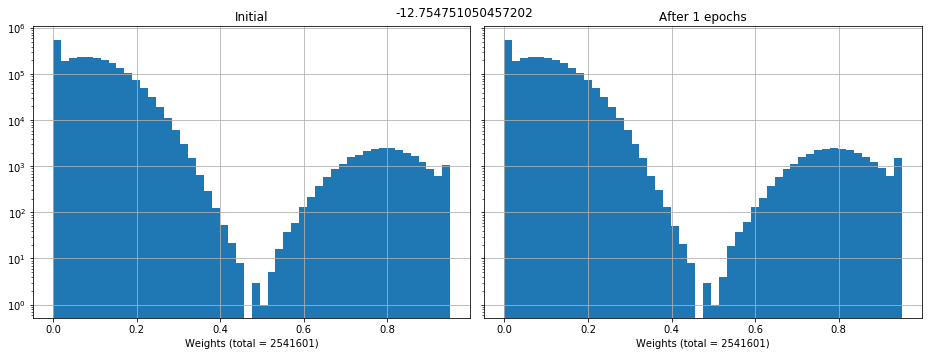

../titan/data_gen0000000023_ind0000000011.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 2.3658087681584394,
 'A_plus': 0.6615940953972844,
 'conn_dist': 21.0,
 'exp_prob': 0.08629867181312727,
 'expand': 14.999401834411861,
 'mushroom_weight': 1.3237080526515839,
 'out_prob': 0.07062688912420899,
 'out_weight': 0.9079657555123175,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}
../titan/data_gen0000000023_ind0000000010.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 4.544786270792846,
 'A_plus': 2.1098474160294867,
 'conn_dist': 21.0,
 'exp_prob': 0.017195941939547744,
 'expand': 6.002865260594332,
 'mushroom_weight': 0.8370663638162885,
 'out_prob': 0.05922611345191683,
 'out_weight': 0.6022975172850514,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


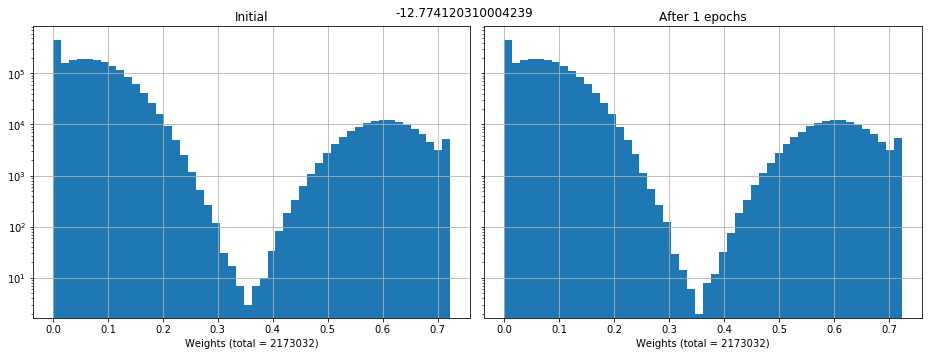

../titan/data_gen0000000023_ind0000000009.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 6.555280918025722,
 'A_plus': 9.689086512904705,
 'conn_dist': 15.0,
 'exp_prob': 0.04297570945231475,
 'expand': 13.937700447479578,
 'mushroom_weight': 1.0970367336538185,
 'out_prob': 0.0873650223228606,
 'out_weight': 0.6962824003002956,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


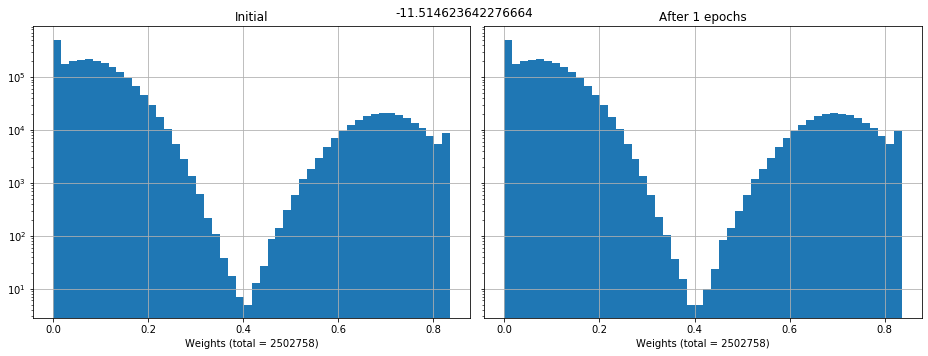

../titan/data_gen0000000023_ind0000000008.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.5203217643554584,
 'A_plus': 4.747624392801162,
 'conn_dist': 8.0,
 'exp_prob': 0.03844645456869724,
 'expand': 19.983218843615287,
 'mushroom_weight': 1.609295757446718,
 'out_prob': 0.08425930855217667,
 'out_weight': 2.0,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


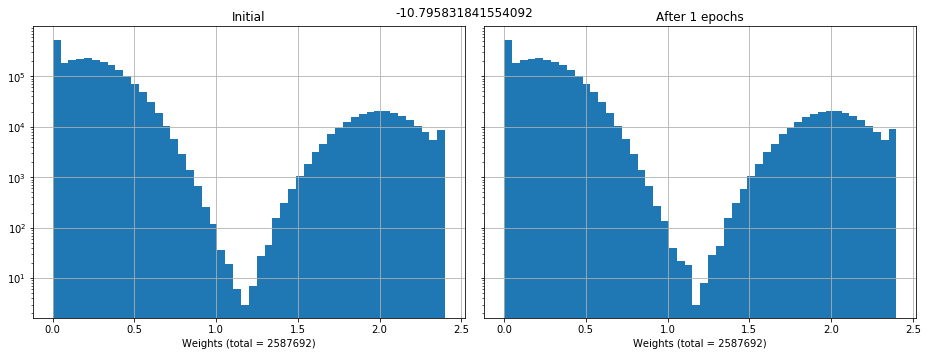

../titan/data_gen0000000023_ind0000000007.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 5.203127095405284,
 'A_plus': 0.15204251937295152,
 'conn_dist': 23.0,
 'exp_prob': 0.04607763005401919,
 'expand': 6.6482618735374235,
 'mushroom_weight': 1.1631743129844139,
 'out_prob': 0.07869556731104005,
 'out_weight': 1.2020633517441106,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


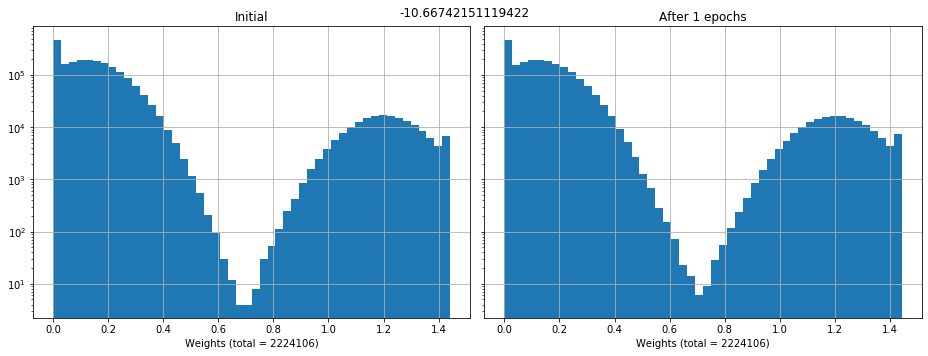

../titan/data_gen0000000023_ind0000000006.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 1.4510037775566467,
 'A_plus': 9.988672481161126,
 'conn_dist': 6.0,
 'exp_prob': 0.07646114087628693,
 'expand': 6.8302522221069815,
 'mushroom_weight': 0.8520711522602166,
 'out_prob': 0.09924715863245022,
 'out_weight': 0.9256330911885855,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


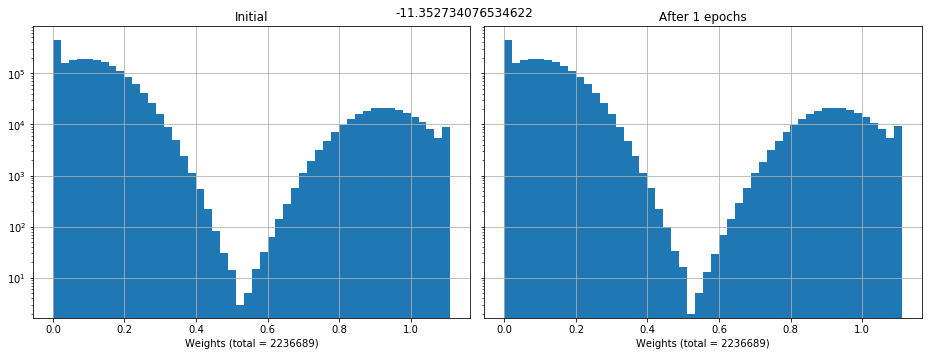

../titan/data_gen0000000023_ind0000000005.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.3439533729967767,
 'A_plus': 8.97169193269782,
 'conn_dist': 7.0,
 'exp_prob': 0.06342168971565387,
 'expand': 8.349198996484073,
 'mushroom_weight': 1.9175657608661392,
 'out_prob': 0.09652146755832866,
 'out_weight': 1.0161872177159725,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


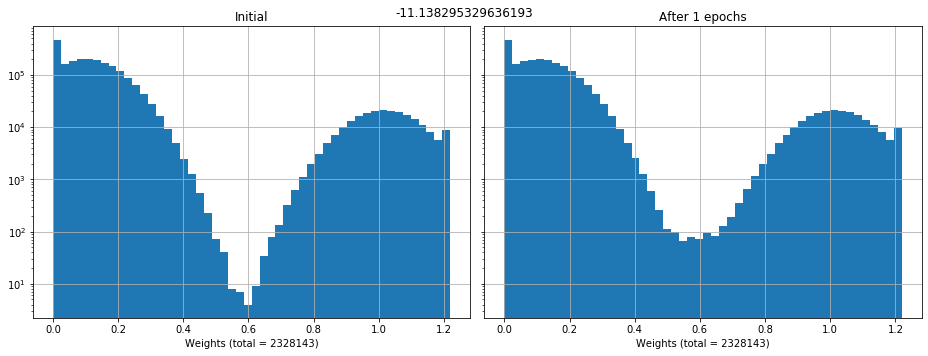

../titan/data_gen0000000023_ind0000000004.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 8.030773676940779,
 'A_plus': 2.9249179863802954,
 'conn_dist': 20.0,
 'exp_prob': 0.0874064772989386,
 'expand': 10.259568318347739,
 'mushroom_weight': 1.6013483299759872,
 'out_prob': 0.017857961500930268,
 'out_weight': 0.3835474271017292,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}
../titan/data_gen0000000023_ind0000000003.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 6.625782444903632,
 'A_plus': 3.6214974496194863,
 'conn_dist': 20.0,
 'exp_prob': 0.021432239407277218,
 'expand': 5.5789809539415405,
 'mushroom_weight': 0.6611053362870395,
 'out_prob': 0.04111789625761649,
 'out_weight': 1.673014330057156,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


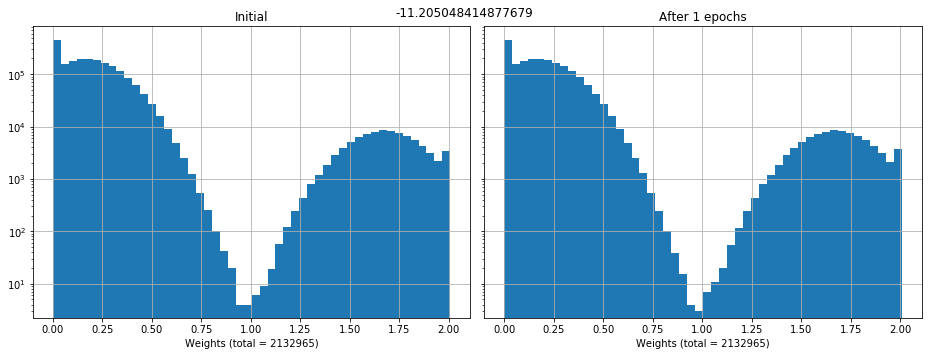

../titan/data_gen0000000023_ind0000000002.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.01,
 'A_plus': 0.07137997850969464,
 'conn_dist': 12.0,
 'exp_prob': 0.1,
 'expand': 8.95159592653053,
 'mushroom_weight': 1.3966251330017976,
 'out_prob': 0.09179134113529569,
 'out_weight': 2.0,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


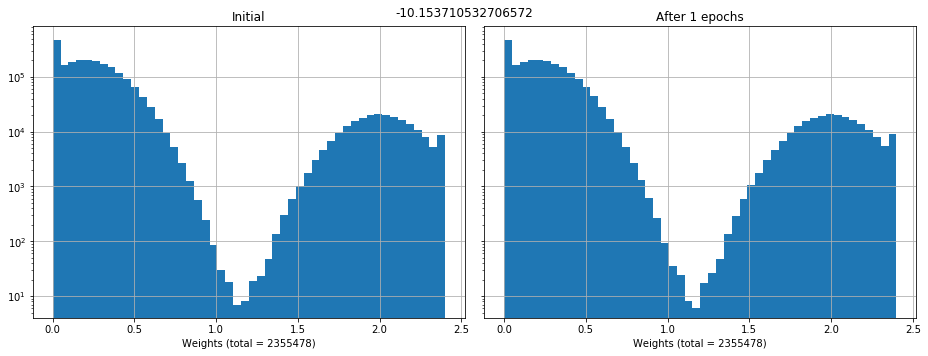

../titan/data_gen0000000023_ind0000000001.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.01,
 'A_plus': 0.07137997850969464,
 'conn_dist': 12.0,
 'exp_prob': 0.1,
 'expand': 11.43519435239359,
 'mushroom_weight': 1.3966251330017976,
 'out_prob': 0.09179134113529569,
 'out_weight': 2.0,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


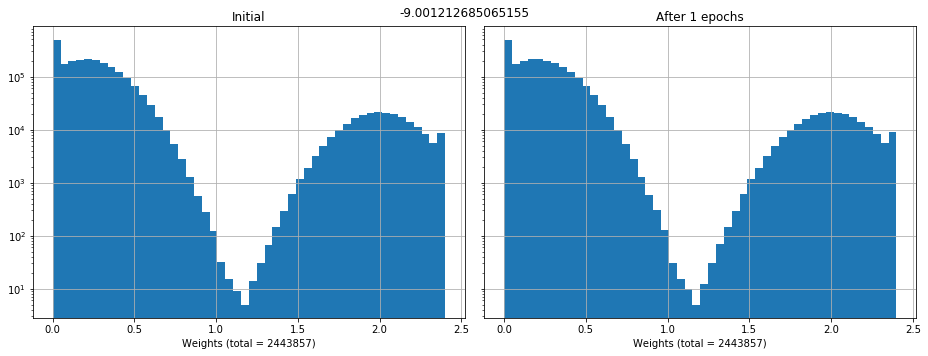

../titan/data_gen0000000023_ind0000000000.npz
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 0.01,
 'A_plus': 0.07137997850969464,
 'conn_dist': 12.0,
 'exp_prob': 0.1,
 'expand': 11.43519435239359,
 'mushroom_weight': 1.8091504141941674,
 'out_prob': 0.09179134113529569,
 'out_weight': 2.0,
 'w_max_mult': 1.2,
 'w_min_mult': -1.0}


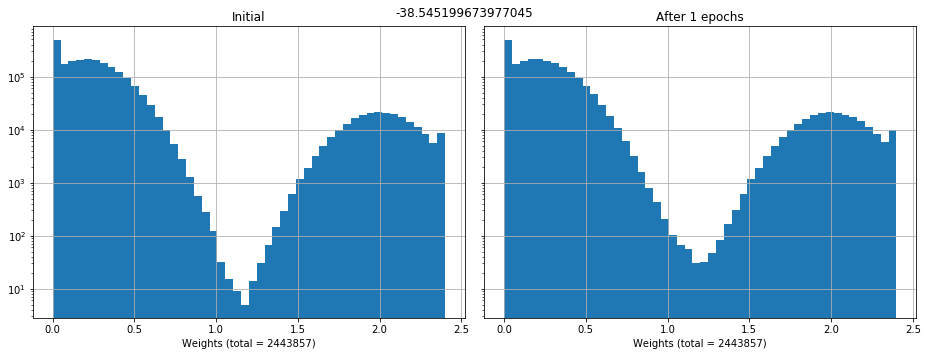

In [10]:
data_path = "../titan"
file_names = sorted( glob.glob(os.path.join(data_path, 'data_gen*0023_*.npz')), reverse=True )
log_scale = bool(1)
for fidx, f in enumerate(file_names):
    print(f)
    # data = to_dict( np.load(file_names[3]) )
    data = to_dict( np.load(f, allow_pickle=True) )
    print(data.keys())
    sim_ps = data['params']['sim']
    epochs = sim_ps['num_epochs']
    #pprint(sim_ps)
    ind_ps = data['params']['ind']
    pprint(ind_ps)
    sim_fit = data['fitness']
    if sim_fit <= -196.:
        continue
    weights = data['weights']['mushroom to output']
    #print(weights.shape)
    start_w = np.ones_like(weights)*np.nan
    w_list = data['weights']['initial']
    #print(len(w_list))
    for row, col, v, d in w_list:
        start_w[int(row), int(col)] = v

    whr = np.where(~np.isnan(start_w))
    ws = start_w[whr]
    whr = np.where(ws > -np.inf)
    n_w = len(whr[0])
    
    # plt.figure(figsize=(13, 5))
    fig, [ax0, ax1] = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13, 5))
    fig.suptitle(sim_fit)
    # ax0 = plt.subplot(1, 2, 1)`
    ax0.hist(ws[whr], bins=50, log=log_scale)
    ax0.set_title('Initial')
    ax0.set_xlabel('Weights (total = {})'.format(n_w))
    ax0.grid()
    

    whr = np.where(~np.isnan(weights))
    n_w = len(whr[0])
    ws = weights[whr]
    #print(ws.size)
    whr = np.where(ws > -np.inf)

    # ax1 = plt.subplot(1, 2, 2)
    d = ax1.hist(ws[whr], bins=50, log=log_scale)
    ax1.set_title('After {} epochs'.format(epochs))
    ax1.set_xlabel('Weights (total = {})'.format(n_w))

    ax1.grid()
    plt.tight_layout()
    plt.savefig('output_weight_distribution_idx_{}_{}_epochs.png'.format(fidx, epochs),
               dpi=150)
    # print(d)
    plt.show()

    # whr = np.where(~np.isnan(weights))
    # ws = weights[whr]
    # print(ws.size)
    # whr = np.where(ws < 0)
    # plt.figure()
    # d = plt.hist(ws[whr], bins=50)
    # print(d)
    # plt.show()

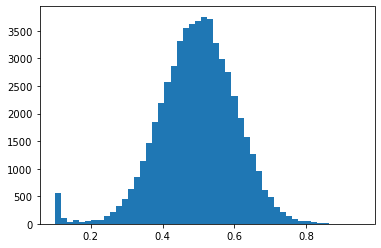

In [32]:
whr = np.where(~np.isnan(weights))
ws = weights[whr]
whr = np.where(np.logical_and(ws > 0.1, ws < 5))
plt.figure()
plt.hist(ws[whr], bins=50)
plt.show()

In [4]:
sim_ps = data['params']['sim']
dt = sim_ps['sample_dt']
n_class = sim_ps['num_classes']
n_test = sim_ps['test_per_class'] * n_class

spikes = data['recs']['output'][0]['spikes']
labels = data['input']['labels']

n_out = len(spikes)
out_per_class = n_out // n_class

start_t = get_test_label_idx(data) * dt
end_t = start_t + n_test *  dt
out_spikes, out_labels = get_test_spikes_and_labels(data)
apc, ipc = analysis.spiking_per_class(labels, spikes, start_t, end_t, dt)

In [5]:
act_per_samp = activity_per_sample(out_labels, out_spikes, start_t, dt)

punish_activity = error_sample_target_activity(target=out_per_class, activity_per_sample=act_per_samp)
reward_distance = mean_per_sample_class_distance(act_per_samp, out_labels, n_out)

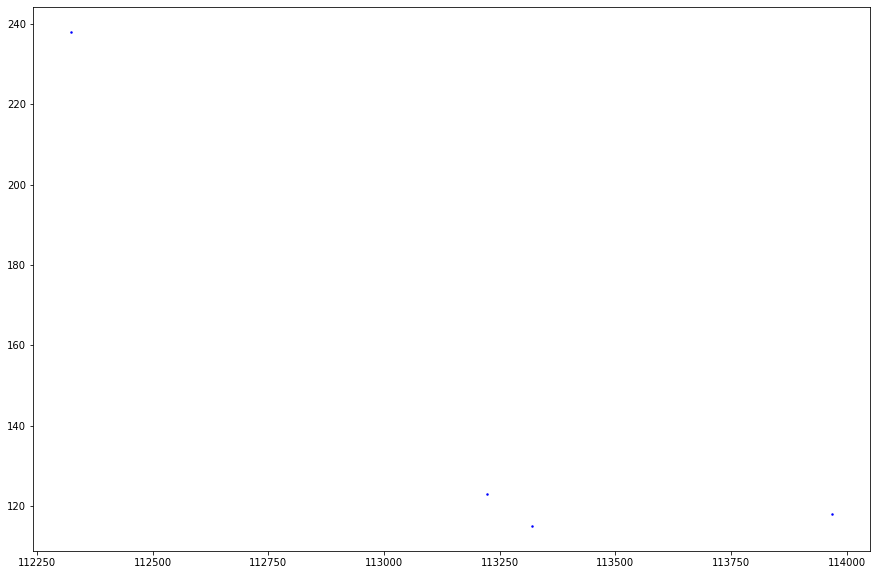

In [6]:
# plt.close('all')
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)

for idx, ts in enumerate(out_spikes):
    plt.plot(ts, np.ones_like(ts) * idx, '.b', 
            markersize=5, markeredgewidth=0)

# ts = (np.arange(len(out_labels)) + get_test_label_idx(data)) * dt
# n_ts = float(ts.size)
# n_out = len(out_spikes)
# lbl_y = n_out + 5
# for idx, t in enumerate(ts):
#     lbl = out_labels[idx]
#     plt.text(t, lbl_y, "{}".format(lbl))
plt.show()

In [7]:
# plt.figure(figsize=(10, 10))

# plot_test_map(out_labels, out_spikes, start_t, dt, 5)

# plt.show()

In [8]:
labels_per_neuron = get_labels_per_neuron(out_labels, out_spikes, start_t, dt)
not_single = {k: labels_per_neuron[k] for k in labels_per_neuron if len(labels_per_neuron[k]) > 1}
not_single_uni = {k: not_single[k] for k in not_single if len(np.unique(not_single[k])) == 1}
# pprint(not_single)
pprint(not_single_uni)

{}


56
4.0
112000.0
1969.0
39.38
[]
280 14 20.0


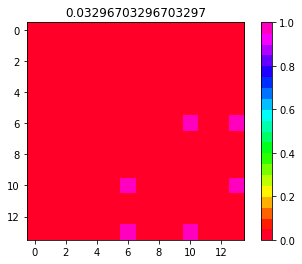

In [9]:
n_out = len(out_spikes)
max_t, max_nid = get_max_t(out_spikes)
print(len(out_labels))
print(len(out_labels)/n_class)
print(start_t)
print(max_t - start_t)
print((max_t - start_t)/dt)
neurons_per_label = get_neurons_per_label(out_labels, out_spikes, start_t, dt)
vectors = [np.zeros(n_out) for _ in neurons_per_label]
for l in neurons_per_label:
    vectors[l][neurons_per_label[l]] = 1
print(vectors_above_threshold(vectors, int(n_out*0.3)))
n_out = len(out_spikes)
n_class = data['params']['sim']['num_classes']
# max_d = n_out/float(n_class)
max_d = 200.#float(n_out - n_class - 1)
print(n_out, n_class, n_out/float(n_class))
dists = get_distances(neurons_per_label) #/ max_d
# vmax = np.sqrt(len(out_spikes))
# vmax = len(out_spikes)/2
# vmax = np.sqrt(2)
vmax = 1.0

# print(colors[0])
unique_d = []
for i in range(dists.shape[0])[:-1]:
    for j in range(i+1, dists.shape[0]):
        unique_d.append(dists[i, j])
# print(unique_d)
# colors = discrete_cmap(int(np.ceil(vmax)), 'gist_rainbow')
# colors = discrete_cmap(int(np.ceil(np.mean(unique_d))), 'gist_rainbow')
colors = discrete_cmap(20, 'gist_rainbow')

plt.figure()
ax = plt.subplot(1, 1, 1)
ax.set_title(np.mean(unique_d))
im = plt.imshow(dists, interpolation='nearest', cmap=colors)#, vmax=vmax)
plt.colorbar(im)
plt.show()

000 ../titan/data_gen*000_*npz 2
100.0


0: ../titan/data_gen0000000000_ind0000000001.npz
avg_sharing_class_error = 0.0000
avg_class_sample_distance = 0.1552
avg_activity_error = 188.2857 sqrt = 13.7217
simulation fitness = -188.1304945054945
comp fitness = 0.0000


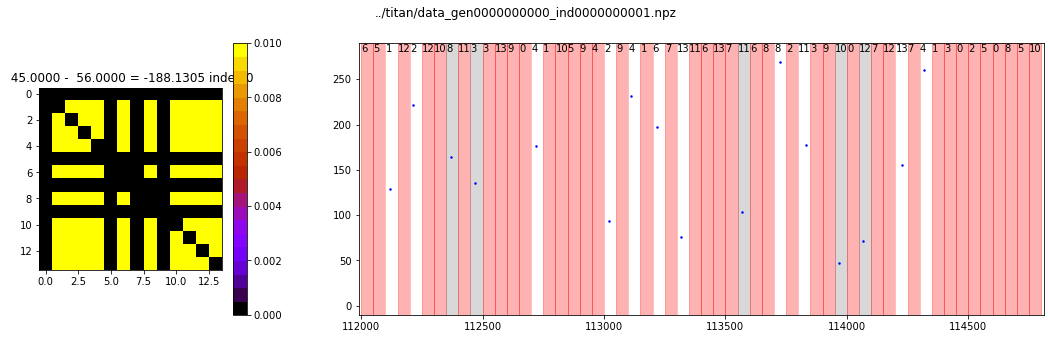

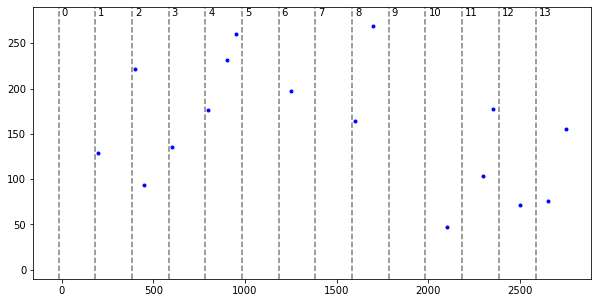

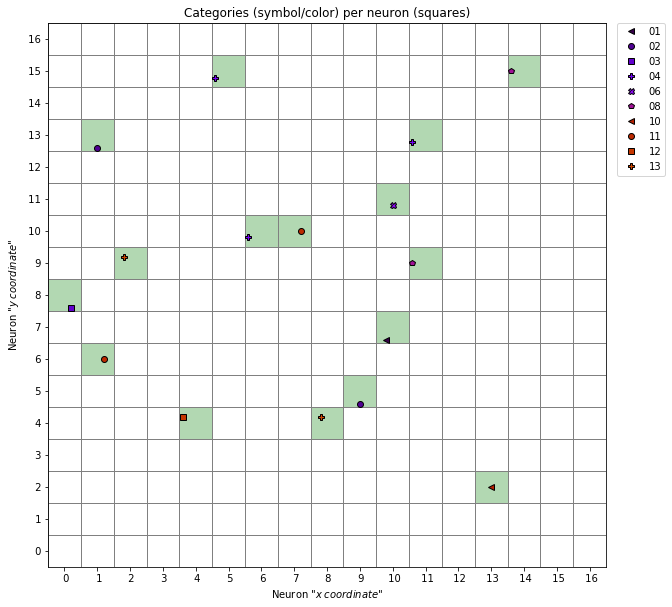



1: ../titan/data_gen0000000000_ind0000000000.npz
avg_sharing_class_error = 0.0059
avg_class_sample_distance = 0.1181
avg_activity_error = 189.2500 sqrt = 13.7568
simulation fitness = -189.13778529163145
comp fitness = 0.0000


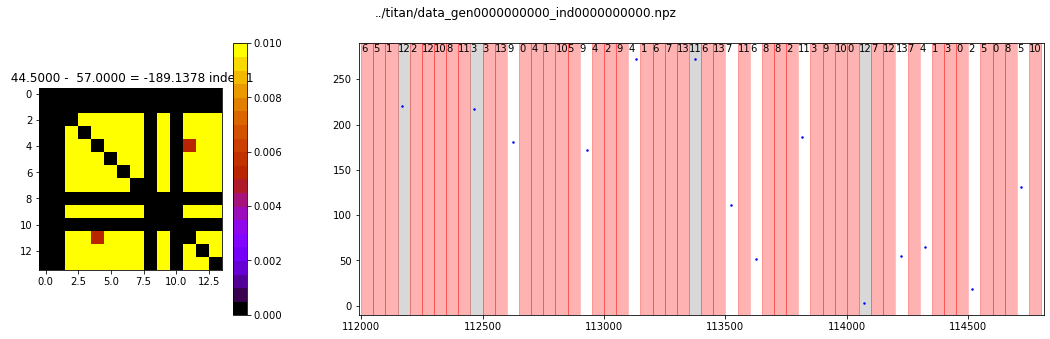

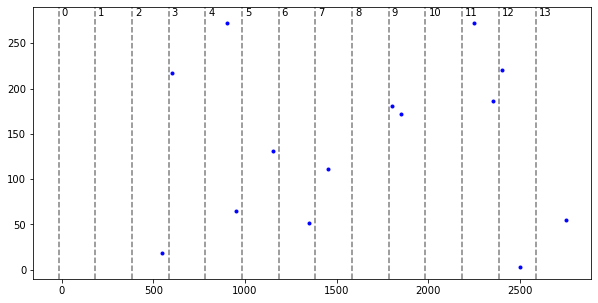

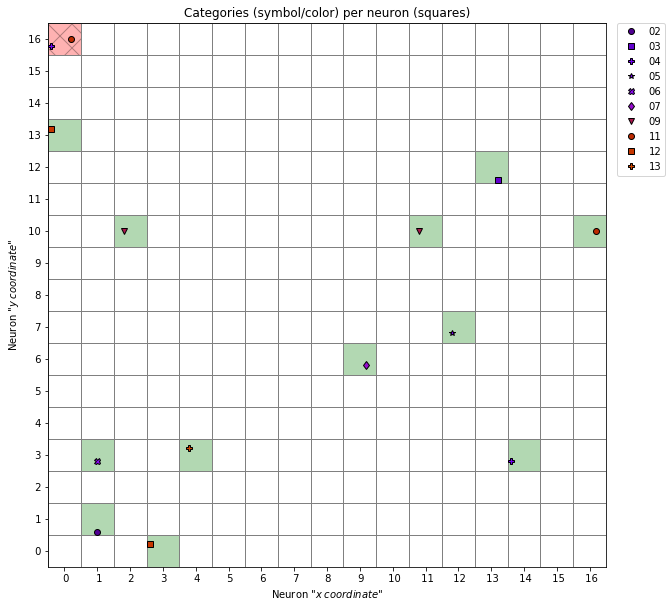

In [18]:
data_path = "../titan"
# data_path = "../titan_freq_punish_added"
# data_path = "../titan_shared_square"

gen = '000'
search_pat = os.path.join(data_path, f'data_gen*{gen}_*npz')
file_names = sorted(
    glob.glob(search_pat), reverse=True ) # newest first
print(gen, search_pat, len(file_names))
colors = discrete_cmap(20, 'gnuplot')
cmap = matplotlib.cm.get_cmap('gnuplot')
_COLORS = [cmap(v) for v in np.arange(0., 1., 1./20.)]

max_d = 100.0
print(max_d)
data = {}
all_lengths = []
all_dists = []
max_vecs = []
max_d_s = -np.inf
max_labels = None
max_spikes = None
max_start_t = None
max_dt = None
max_npl = None
max_idx = None
fine_dists = []
target_activs = []
for fidx, f in enumerate(file_names[:]):
    print(f"\n\n{fidx}: {f}")
    with np.load(f, allow_pickle=True) as d:
        data = to_dict( d )
    sim_ps = data['params']['sim']
    dt = sim_ps['sample_dt']
    n_class = sim_ps['num_classes']
    n_test = sim_ps['test_per_class'] * n_class
    test_per_class = sim_ps['test_per_class']
    spikes = data['recs']['output'][0]['spikes']
    labels = data['input']['labels']

    analysis = data['analysis']
    avg_sharing_class_error = analysis['aggregate_per_class']['avg_sharing_class_error']
#     avg_freq_error = analysis['aggregate_per_class']['avg_freq_error']
    avg_class_sample_distance = analysis['individual_per_class']['avg_class_samp_distance']
    avg_activity_error = analysis['individual_per_class']['avg_activity_error']
    sqrt_avg_activity_error = np.sqrt(avg_activity_error)
    sim_fit = data['fitness']
    
    print(f'avg_sharing_class_error = {avg_sharing_class_error:0.4f}')
    print(f'avg_class_sample_distance = {avg_class_sample_distance:0.4f}')
    print(f'avg_activity_error = {avg_activity_error:0.4f} sqrt = {sqrt_avg_activity_error:0.4f}')
#     print(f'avg_freq_error = {avg_freq_error:0.4f}')
    print(f'simulation fitness = {sim_fit}')
#     comp_fit = avg_class_sample_distance - avg_activity_error - avg_sharing_class_error - avg_freq_error
    comp_fit = 0
    print(f'comp fitness = {comp_fit:0.4f}')
    n_out = len(spikes)
    out_per_class = n_out // n_class

    start_t = get_test_label_idx(data) * dt
    end_t = start_t + n_test *  dt
    
    start_t = get_test_label_idx(data) * dt
    out_spikes, out_labels = get_test_spikes_and_labels(data)
    end_t = start_t + len(out_labels) * dt
    n_out = len(out_spikes)
    
    total_test_rate = np.sum([len(ts) for ts in out_spikes])
    mean_test_rate = total_test_rate #/ float(n_out)
#     print(f"total_test_rate = {total_test_rate} : average = {mean_test_rate}")
    
    high_thresh = sim_ps['num_classes'] * sim_ps['test_per_class'] * 0.5
    high, rates = high_rate(start_t, out_spikes, n_class)
    n_high = len(high)
#     print(f'high rate (> {high_thresh}) neurons {high} \n rate {rates}')
    
    
    labels_per_neuron = get_labels_per_neuron(
                            out_labels, out_spikes, start_t, dt)
    num_labels_for_neurons = [len(np.unique(labels_per_neuron[k])) for k in labels_per_neuron]
    hi_num_labels_for_neurons = [n for n in num_labels_for_neurons if n > 1]
#     avg_num_labels_per_neuron = np.mean(hi_num_labels_for_neurons)
    avg_num_labels_per_neuron = len(hi_num_labels_for_neurons)
#     avg_num_labels_per_neuron = n_class * n_out if np.isnan(avg_num_labels_per_neuron) else avg_num_labels_per_neuron
    
    neurons_per_label = get_neurons_per_label(
                            out_labels, out_spikes, start_t, dt)
    all_lengths += [len(np.unique(neurons_per_label[k])) for k in neurons_per_label]
    dists = get_distances(neurons_per_label) 
    unique_d = []
    for i in range(dists.shape[0])[:-1]:
        for j in range(i+1, dists.shape[0]):
            unique_d.append(dists[i, j])
    
    all_dists += unique_d
    
    max_unique = np.max(unique_d)
#     print(f'maximum manhattan {max_unique}')
    if np.sum(unique_d) > 0 and sim_fit > 0:
        all_dists += unique_d
    
    
    vectors = [np.zeros(n_out) for _ in neurons_per_label]
    for l in sorted(neurons_per_label.keys()):
        vectors[l][neurons_per_label[l]] = 1
    
    
    max_l = np.max([np.sum(v) for v in vectors])
#     print(f'maximum vector length {max_l}')
    
    aps = activity_per_sample(out_labels, out_spikes, start_t, dt)
    sorted_aps = sort_activity_per_sample(out_labels, aps)
    n_aps = [len(v) for v in aps]
    n_tests = len(n_aps)
    n_zero_aps = np.sum([1 for s in n_aps if s == 0])
    
    above_thr = vectors_above_threshold(vectors, int(n_out*0.3))
    zeros = [i for i, v in enumerate(vectors) if np.sum(v) <= 0.1]
    pabove = len(above_thr)# / float(n_class)
    pzero_accum = 0#len(zeros)# / float(n_class)
    pzero_ind = n_zero_aps#/float(n_tests)
#     print(f"vectors above threshold = {above_thr}")
#     print(f"zero sum vector ids = {zeros}")
#     print(f"num active per test sample = {n_aps}\n\tnum of zero active = {n_zero_aps}")

#     punish = 1.0 * (pabove + pzero_accum + pzero_ind + avg_num_labels_per_neuron + n_high * mean_test_rate)
#     print("{punish} = ({pabove} + {pzero_accum} + {pzero_ind} + {avg_n_labels} + {n_high * mean_test_rate})")
#     print(f"{punish} = ({pabove} + {pzero_accum} + {pzero_ind} + {avg_num_labels_per_neuron} + {n_high * mean_test_rate})")
    punish = 1.0 * (pabove + pzero_accum + pzero_ind + avg_num_labels_per_neuron + mean_test_rate)
#     print("{punish} = ({pabove} + {pzero_accum} + {pzero_ind} + {avg_n_labels} + {mean_test_rate})")
#     print(f"{punish} = ({pabove} + {pzero_accum} + {pzero_ind} + {avg_num_labels_per_neuron} + {mean_test_rate})")
#     avg = np.mean(np.clip(unique_d, 0., 50.0))
    avg = np.sum(unique_d)
#     avg = np.mean(unique_d)
    cont_avg = np.copy(avg)
#     vmax = np.sqrt(len(out_spikes))
#     vmax = len(out_spikes) / 2.0
#     colors = discrete_cmap(int(np.ceil(vmax)), 'gist_rainbow')
#     try:
#         colors = discrete_cmap(int(np.ceil(max_d)), 'gist_rainbow')
#     except:
#         colors = 'gist_rainbow'
#     max_d = max_unique
#     max_d = 50
#     avg = np.clip(avg/max_d, 0., 1.0) * 0.3
    act_per_samp = activity_per_sample(out_labels, out_spikes, start_t, dt)

    punish_activity = error_sample_target_activity(target=out_per_class, activity_per_sample=act_per_samp)
    punish_activity /= float(n_out)
    reward_distance = mean_per_sample_class_distance(act_per_samp, out_labels, n_out)
#     print(f'punish_activity = {punish_activity}')
#     print(f'reward_distance = {reward_distance}')
    target_activs.append(punish_activity)
    fine_dists.append(reward_distance)
    
    local_max = reward_distance - punish_activity
#     local_max = avg / punish
    local_max = sim_fit
#     local_max = comp_fit
#     local_max = np.max(dists)
    if local_max > max_d_s:
        max_d_s = local_max
        max_vecs = neurons_per_label
        max_labels = out_labels
        max_spikes = out_spikes
        max_start_t = start_t
        max_npl = neurons_per_label
        max_dt = dt
        max_idx = fidx

#     continue
    
#     if cont_avg < -28.0:
#     if sim_fit == -196. or sim_fit < -1000.:
#         print(f"zero avg {avg:8.4f} index {fidx}")
#         continue
        
    fig = plt.figure(figsize=(18, 5))
    widths = [1, 3]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
    plt.suptitle(f)
    ax = fig.add_subplot(spec[0, 0])
    ax.set_title(f"{avg:8.4f} - {punish:8.4f} = {local_max:8.4f} index {fidx}")
    im = plt.imshow(dists/max_d, interpolation='nearest', cmap=colors)#, vmax=1.0)
    plt.colorbar(im)
#     fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(spec[0, 1])
    gray = False
    for t in np.arange(start_t, end_t, dt):
        idx = int((t-start_t) // dt)
        clr = 'gray' if gray else 'white'
        gray = not gray
        if empty(t, dt, out_spikes):
            clr = 'red'

        plt.axvspan(t, t+dt, color=clr, alpha=0.3)
        lbl = out_labels[idx]
        plt.text(t, n_out, f"{lbl}")

    
    for idx, ts in enumerate(out_spikes):
        plt.plot(ts, np.ones_like(ts) * idx, '.b', 
                markersize=5, markeredgewidth=0)
    ax.set_xlim(start_t - 10, end_t + 10)
    ax.set_ylim(-10, n_out+10)
#     plt.figure()
#     plot_test_map(out_labels, out_spikes, start_t, dt, 10)

    plt.figure(figsize=(10, 5))
    ax = plt.subplot(1, 1, 1)
    for idx in range(len(sorted_aps)):
        cls = idx // test_per_class
        ttt = dt * idx
        if (idx % test_per_class) == 0:
            plt.axvline(ttt-dt//3, color='gray', linestyle='--')
            plt.text(ttt, n_out, f'{cls}')

        for y in sorted_aps[idx]:
            plt.plot(ttt, y, '.b')

    ax.set_ylim(-10, n_out+10)
    
    
    if len(zeros) < n_class:
        plt.figure(figsize=(10, 10))
        plot_test_map_single(out_labels, out_spikes, start_t, dt, 6, colors=_COLORS)


        
    
    plt.show()

#     print(f)
#     print("distance sum = {:8.4f}".format(dists.sum()))

print()

In [14]:
print(max_idx)
# 47
# max_idx = 29
# np.sqrt(19100)

0


{'A_minus': 3.563797432887518,
 'A_plus': 3.417631212925509,
 'conn_dist': 5.0,
 'exp_prob': 0.1,
 'expand': 10.0,
 'mushroom_weight': 1.0,
 'out_prob': 0.3003980502093835,
 'out_weight': 1.7897285325193752,
 'w_max_mult': 1.2,
 'w_min_mult': -6.2974924520960505}
{'database': ['Braille'],
 'duration': 114800.0,
 'input_divs': (3, 5),
 'input_layers': 4,
 'input_shape': (56, 56),
 'kernel_pad': 3,
 'kernel_width': 7,
 'noisy_spikes_path': '/its/home/gp283/l2l-omniglot/L2L-OMNIGLOT',
 'num_classes': 14,
 'num_epochs': 10,
 'num_sims': 1,
 'on_juwels': False,
 'output_size': 280,
 'prob_noise': 0.1,
 'sample_dt': 50.0,
 'samples_per_class': 16,
 'spikes_path': '/its/home/gp283/omniglot_output_56',
 'steps': 1,
 'test_per_class': 4,
 'total_per_class': 164,
 'use_gabor': False}
dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'analysis', 'fitness0', 'fitness1', 'fitness'])
simulation fitness = -196.0
avg_freq_error = 4.0


ValueError: not enough values to unpack (expected 2, got 0)

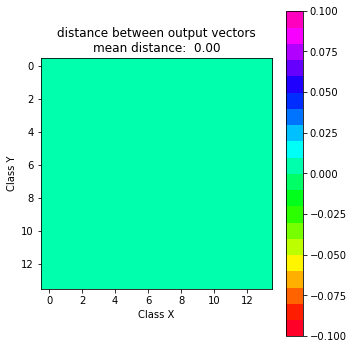

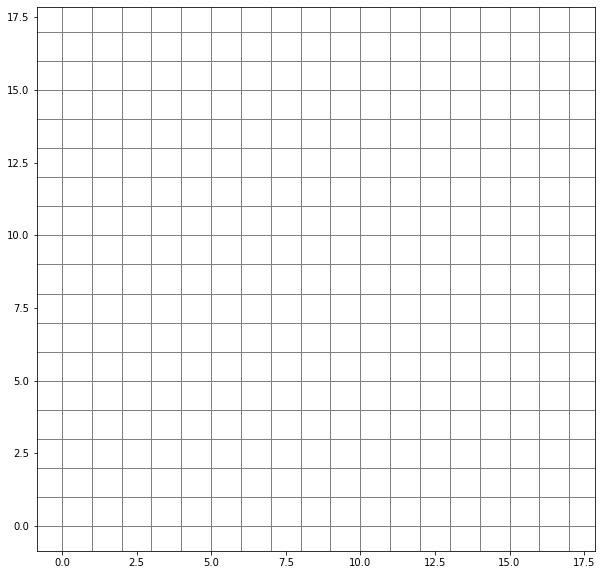

In [15]:

    
fname = file_names[max_idx]
# fname = file_names[12]
with np.load(fname, allow_pickle=True) as d:
    data = to_dict( d )
ind_ps = data['params']['ind']
pprint(ind_ps)
sim_ps = data['params']['sim']
pprint(sim_ps)
print(data.keys())
dt = sim_ps['sample_dt']
start_t = get_test_label_idx(data) * dt
end_t = start_t + len(out_labels) * dt
test_per_class = sim_ps['test_per_class']
sim_fit = data['fitness']
print(f'simulation fitness = {sim_fit}')

out_spikes, out_labels = get_test_spikes_and_labels(data)
neurons_per_label = get_neurons_per_label(
                        out_labels, out_spikes, start_t, dt)

n_class = sim_ps['num_classes']

# high_thresh = sim_ps['num_classes'] * sim_ps['test_per_class'] #* 0.5
high_thresh = sim_ps['test_per_class'] #* 0.5
# high = high_rate(start_t, out_spikes, n_class)
# print(f'high (> {high_thresh}) rate neurons {high}')
ids, rates = high_rate(start_t, out_spikes, high_thresh)

avg_freq_error = mean_target_frequency_error(
                    high_thresh, out_spikes, power=1)
print(f'avg_freq_error = {avg_freq_error}')

aps = activity_per_sample(out_labels, out_spikes, start_t, dt)
sorted_aps = sort_activity_per_sample(out_labels, aps)

max_d = 160.0
dists = get_distances(neurons_per_label) #/ max_d
colors = discrete_cmap(20, 'gist_rainbow')
# colors = discrete_cmap(20, 'gnuplot')
unique_d = []
for i in range(dists.shape[0])[:-1]:
    for j in range(i+1, dists.shape[0]):
        unique_d.append(dists[i, j])

cmap = matplotlib.cm.get_cmap('gist_rainbow')
_COLORS = [cmap(v) for v in np.arange(0., 1., 1./14.)]

plt.figure(figsize=(5,5))
# plt.suptitle('')
ax = plt.subplot(1, 1, 1)
avg_d = np.mean(unique_d)
ax.set_title(f'distance between output vectors\nmean distance: {avg_d:5.2f}')
im = plt.imshow(dists, interpolation='nearest', cmap=colors)#, vmax=vmax)
plt.colorbar(im)
ax.set_xlabel('Class X')
ax.set_ylabel('Class Y')
plt.tight_layout()
plt.savefig(f'distances_{gen}.png', dpi=150)

plt.figure(figsize=(10, 10))
plot_test_map(out_labels, out_spikes, start_t, dt, 6, colors=_COLORS)
plt.tight_layout()
plt.savefig(f'map_{gen}.pdf')

plt.figure(figsize=(10, 10))
plot_test_map_single(out_labels, out_spikes, start_t, dt, 6, colors=_COLORS)
plt.tight_layout()
plt.savefig(f'map_single_{gen}.png', dpi=150)



plt.figure(figsize=(15, 7))
ax = plt.subplot(1, 1, 1)
gray = False
for t in np.arange(start_t, end_t, dt):
    idx = int((t-start_t) // dt)
    clr = 'gray' if gray else 'white'
    gray = not gray
    if empty(t, dt, out_spikes):
        clr = 'red'
    plt.axvspan(t, t+dt, color=clr, alpha=0.3)
    lbl = out_labels[idx]
    plt.text(t, n_out, f"{lbl}")


for idx, ts in enumerate(out_spikes):
    plt.plot(ts, np.ones_like(ts) * idx, '.b', 
            markersize=5, markeredgewidth=0)
ax.set_xlim(start_t - 10, end_t + 10)
ax.set_ylim(-10, n_out+10)
plt.tight_layout()
plt.savefig(f'output_spikes_{gen}.png', dpi=150)


plt.figure(figsize=(15, 7))
ax = plt.subplot(1, 1, 1)
for idx in ids:
    plt.axhline(idx, color='red')
for idx in range(len(sorted_aps)):
    cls = idx // test_per_class
    ttt = dt * idx
    if (idx % test_per_class) == 0:
        plt.axvline(ttt-dt//3, color='gray', linestyle='--')
        plt.text(ttt, n_out, f'{cls}')

    for y in sorted_aps[idx]:
        plt.plot(ttt, y, '.b', markersize=3)

ax.set_ylim(-10, n_out+10)
plt.savefig(f'sorted_output_spikes_{gen}.png', dpi=150)

plt.show()


In [ ]:
ad = np.asarray(all_dists)
print(ad.min(), ad.mean(), ad.max())
plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 1, 1)
ax.set_title("distance between vectors")
d = plt.hist(ad, bins=50)
plt.tight_layout()
plt.savefig(f'generation_distances_{gen}.png', dpi=150)
plt.show()
print(d)

nzad = ad[ad > 0]
print(nzad.min(), nzad.mean(), nzad.max())
plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 1, 1)
ax.set_title("distance between vectors")
d = plt.hist(nzad, bins=50)
plt.tight_layout()
plt.savefig(f'nz_generation_distances_{gen}.png', dpi=150)
plt.show()
print(d)

In [ ]:
plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 1, 1)
ax.set_title("Vector lengths")
d = plt.hist(all_lengths, bins=50)
plt.show()
print(d)

---
---
Random vector tests: 
---
Just create random output vectors and quantify maximum distances

In [ ]:

if bool(0):
    n_out = len(out_spikes)
    n_class = data['params']['sim']['num_classes']
    n_rest = n_class - 1

    n_trials = 100000
    max_distances = []
    vecs = []
    indices = set(range(n_out))
    used = set()
    available = set(range(n_out))
    for i in range(n_trials):
        vecs[:] = []
        used.clear()
        available.clear() 
        available |= set(range(n_out))
        for c in range(n_class):
            missing = n_class - c
            max_size = len(available) - (missing - 1)
            size = np.random.randint(0, max_size+1)
            ids = np.random.choice(list(available), size=size)
            v = np.zeros(n_out)
            v[ids] = 1
            vecs.append(v)
            used |= set(ids)
            available -= used

        max_distances.append(max_dist(vecs))

    # for win_length in np.arange(n_out-n_rest, 0, -1):
    #     rest = n_out - win_length
    #     n_on = rest // n_rest
    #     v0 = np.zeros(n_out)
    #     v0[:win_length] = 1

    #     distances.append(win_length + n_on)

    plt.figure()
    plt.hist(max_distances, bins=50)
    # plt.plot(distances)
    plt.show()
    #     print(n_out - win_length)

In [ ]:
max_d = float(n_out - n_class - 1)
md = np.clip(np.asarray(max_distances), 0, 220) / 220.# / np.exp(max_d)
md = np.asarray(max_distances)# / np.exp(max_d)
print(md.min(), md.mean(), md.max())

In [ ]:
plt.figure()
# plt.hist(np.asarray(max_distances)/max_d, bins=50)
plt.hist(md, bins=50)
# plt.plot(distances)
plt.show()
#     print(n_out - win_length)

In [ ]:
plt.figure()
plt.plot(sorted(np.clip(md, 0, 200)/200))
plt.show()

---
---
Random vector distance experiments:
---
Check what is the likely maximum distance for vectors in the output population

---
---

In [ ]:
if bool(1):
    n_out = 280#len(out_spikes)
    n_class = 14#data['params']['sim']['num_classes']
    n_rest = n_class - 1

    n_trials = 100
    max_distances = {}
    vecs = []
    indices = set(range(n_out))
    used = set()
    available = set(range(n_out))
    samples = {}
    for prc in np.arange(1., 1.01, 0.1):
        mdd = []
        for i in range(n_trials):
            vecs[:] = []
            for c in range(n_class):
                max_size = int(n_out * prc)
                size = np.random.randint(0, max_size+1)
                size = min(size, len(available))
#                 size = max_size
                ids = np.random.choice(list(available), size=size, replace=False)
                v = np.zeros(n_out)
                v[ids] = 1
                vecs.append(v)
                slist = samples.get(size, [])
                slist.append(v)
                samples[size] = slist

            mdd.append(max_dist(vecs))
        max_distances[prc] = mdd

In [ ]:
def _mdist(v0, v1, normalize=True):
    s = 0.
    if np.sum(v0) >= 1 and np.sum(v1) >= 1:
        s = np.sum(np.abs(v0 - v1))
        if normalize:
            s *= 1./(np.sum(v0) + np.sum(v1))
    return s

sizes = sorted(samples.keys())
max_s = np.max(sizes)
min_s = np.min(sizes)
print(min_s, max_s)
n_sizes = max_s - min_s
dists = np.ones((n_sizes+1, n_sizes+1)) * np.nan
_ds = []
for s0 in sizes:
    sys.stdout.write(f"\r{s0}")
    sys.stdout.flush()

    for s1 in sizes:

        _ds[:] = [_mdist(v0, v1)
                    for v0 in samples[s0] 
                        for v1 in samples[s1] if not np.all(v0==v1)]
        if len(_ds):
            dists[s0-min_s, s1-min_s] = np.mean(_ds)


In [ ]:
plt.figure(figsize=(14, 10))
ax = plt.subplot(1, 1, 1)
ax.set_title('normalization = (magn(v0) + magn(v1))')
plt.imshow(dists, cmap='gist_rainbow', interpolation='none')
plt.colorbar()
plt.savefig('plot_magn_sum.png', dpi=150)
plt.show()


In [ ]:
def _mdist(v0, v1, threshold=1,normalize=True):
    s = 0.
    if np.sum(v0) >= threshold and np.sum(v1) >= threshold:
        s = np.sum(np.abs(v0 - v1))
        if normalize:
            sv0 = np.sum(v0)
            sv1 = np.sum(v1)
#             n = np.sqrt(sv0+sv1)
            n = (max(sv0, sv1))#/min(sv0, sv1))
            s *= 1./n
    return s

sizes = sorted(samples.keys())
max_s = np.max(sizes)
min_s = np.min(sizes)
print(min_s, max_s)
n_sizes = max_s - min_s
dists_max = np.ones((n_sizes+1, n_sizes+1)) * np.nan
_ds = []
for s0 in sizes:
    sys.stdout.write(f"\r{s0}")
    sys.stdout.flush()

    for s1 in sizes:

        _ds[:] = [_mdist(v0, v1, 1)
                    for v0 in samples[s0] 
                        for v1 in samples[s1] if not np.all(v0==v1)]
        if len(_ds):
            dists_max[s0-min_s, s1-min_s] = np.mean(_ds)


In [ ]:
plt.figure(figsize=(14, 10))
ax = plt.subplot(1, 1, 1)
ax.set_title('normalization = max(magn(v0), magn(v1))')
plt.imshow(dists_max/2, cmap='gist_rainbow', interpolation='none')
plt.colorbar()
plt.savefig('plot_magn_max.png', dpi=150)
plt.show()


In [ ]:
def _mdist(v0, v1, threshold=1,normalize=True):
    s = 0.
    if np.sum(v0) >= threshold and np.sum(v1) >= threshold:
        n0 = np.sqrt(np.sum(v0**2))
        n1 = np.sqrt(np.sum(v1**2))
        dot = np.dot(v0, v1)
        c = dot / (n0*n1)
        s = np.degrees(np.arccos(c))
#         s = c
    return s

sizes = sorted(samples.keys())
max_s = np.max(sizes)
min_s = np.min(sizes)
print(min_s, max_s)
n_sizes = max_s - min_s
dists_max = np.ones((n_sizes+1, n_sizes+1)) * np.nan
_ds = []
for s0 in sizes:
    sys.stdout.write(f"\r{s0}")
    sys.stdout.flush()

    for s1 in sizes:

        _ds[:] = [_mdist(v0, v1, 1)
                    for v0 in samples[s0] 
                        for v1 in samples[s1] if not np.all(v0==v1)]
        if len(_ds):
            dists_max[s0-min_s, s1-min_s] = np.mean(_ds)


In [ ]:
plt.figure(figsize=(14, 10))
ax = plt.subplot(1, 1, 1)
ax.set_title('angle(v0, v1)')
plt.imshow(dists_max, cmap='gist_rainbow', interpolation='none')
plt.colorbar()
plt.savefig('plot_cos_dist.png', dpi=150)
plt.show()


In [ ]:
def _mdist(v0, v1, threshold=1,normalize=True):
    s = 0.
    if np.sum(v0) >= threshold and np.sum(v1) >= threshold:
        s = np.sqrt(np.sum((v0 - v1)**2))
    return s

sizes = sorted(samples.keys())
max_s = np.max(sizes)
min_s = np.min(sizes)
print(min_s, max_s)
n_sizes = max_s - min_s
dists_max = np.ones((n_sizes+1, n_sizes+1)) * np.nan
_ds = []
for s0 in sizes:
    sys.stdout.write(f"\r{s0}")
    sys.stdout.flush()

    for s1 in sizes:

        _ds[:] = [_mdist(v0, v1, 1)
                    for v0 in samples[s0] 
                        for v1 in samples[s1] if not np.all(v0==v1)]
        if len(_ds):
            dists_max[s0-min_s, s1-min_s] = np.mean(_ds)


In [ ]:
plt.figure(figsize=(14, 10))
ax = plt.subplot(1, 1, 1)
ax.set_title('euclidean')
plt.imshow(dists_max, cmap='gist_rainbow', interpolation='none')
plt.colorbar()
plt.tight_layout()
plt.savefig('plot_euc_dist.png', dpi=150)
plt.show()


In [ ]:
# for win_length in np.arange(n_out-n_rest, 0, -1):
#     rest = n_out - win_length
#     n_on = rest // n_rest
#     v0 = np.zeros(n_out)
#     v0[:win_length] = 1
    
#     distances.append(win_length + n_on)
plt.figure(figsize=(15, 6))
for prc in max_distances:
#     plt.figure(figsize=(15, 6))
    plt.hist(max_distances[prc], bins=50, label=f"{prc:6.4f}", alpha=0.6)
# plt.plot(distances)
    plt.legend()
plt.show()
#     print(n_out - win_length)

In [ ]:
def get_unique_distances(vectors):
    dists = []
    for i0, k0 in enumerate(vectors[:-1]):
        for k1 in vectors[i0+1:]:
#             print(np.sum(k0), np.sum(k1))
            if np.sum(k0) < 1 or np.sum(k1) < 1:
                s = 0.
            else:
                diff = np.abs(k0 - k1)
#                 print(k0, k1, diff)
                s = np.sum(diff)
            dists.append(s)
    return dists

if bool(1):
    all_distances = {}
    n_out = len(out_spikes)
    n_class = data['params']['sim']['num_classes']
    n_rest = n_class - 1

    n_trials = 2000
    max_distances = {}
    vecs = []
    indices = set(range(n_out))
    used = set()
    available = set(range(n_out))
    for prc in np.arange(0.1, 1.1, 0.1):
        ald = []
        mdd = []
        for i in range(n_trials):
            i += 1
            sys.stdout.write(f"\r{prc:4.2f} {i}/{n_trials}")
            sys.stdout.flush()
            vecs[:] = []
            for c in range(n_class):
                max_size = int(n_out * prc)
                size = np.random.randint(1, max_size+1)
#                 size = max_size
                ids = np.random.choice(list(available), size=size, replace=False)
                v = np.zeros(n_out)
                v[ids] = 1
                vecs.append(v)
#             print(vecs)
            
            ald += get_unique_distances(vecs)

            mdd.append(max_dist(vecs))
        sys.stdout.write(f"\n")
        sys.stdout.flush()
        
        all_distances[prc] = ald
        max_distances[prc] = mdd

In [ ]:
# for win_length in np.arange(n_out-n_rest, 0, -1):
#     rest = n_out - win_length
#     n_on = rest // n_rest
#     v0 = np.zeros(n_out)
#     v0[:win_length] = 1
    
#     distances.append(win_length + n_on)
plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 1, 1)
ax.set_title(f'Histograms of distances with maximum vector size')
for prc in all_distances:
#     plt.figure(figsize=(15, 6))
    pprc = int(100 * prc)
    plt.hist(all_distances[prc], bins=50, label=f"{pprc:d}%", alpha=0.6)
# plt.plot(distances)
    plt.legend()
ax.set_xlabel('Manhattan distance')
plt.tight_layout()
plt.savefig('distance_simulations_histograms.png', dpi=150)
plt.show()
#     print(n_out - win_length)

In [ ]:
print([np.mean(all_distances[x]) for x in all_distances])

In [ ]:
print([np.median(all_distances[x]) for x in all_distances])

In [ ]:
files = glob.glob('../titan/filtered_*.npz')
# files = sorted(glob.glob('../titan/filtered_*_data_*.npz'))
# filtered_mushroom_spikes_data_gen*
print(files)

In [ ]:
for f in files:
    with np.load(f, allow_pickle=True) as d:
        data = to_dict(d)
    print(f)
    s = data['spikes']
    n_neurons = len(s)
#     rand_ids = np.random.randint(n_neurons, size=1000)
    rand_ids = np.arange(n_neurons - 1000, n_neurons)
    plt.figure()
    for idx in rand_ids: 
        ts = s[idx]
        ttt = ts[ts < 1000.]
        plt.plot(ttt, idx * np.ones_like(ttt), '.b', markersize=3)
    
    fname = os.path.splitext(os.path.basename(f))[0]
    print(fname)
    plt.savefig(f'{fname:s}.png', dpi=150)
    plt.show()
        
